In [1]:
import os
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw, rdFMCS
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN
from tqdm import tqdm

from geom3d.utils import database_utils
from geom3d.train_models import *
import torch
import copy


In [2]:
os.chdir('/rds/general/user/cb1319/home/GEOM3D/Geom3D/')
config_dir = os.getcwd()+"/performance_eval_test/SchNet_IP_80000"
config = read_config(config_dir)

dataset_path = "/rds/general/user/cb1319/home/GEOM3D/Geom3D/performance_eval_test/80Kdataset.pt"
dataset = torch.load(dataset_path)

config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/performance_eval_test/SchNet_IP_80000


In [3]:
%matplotlib inline

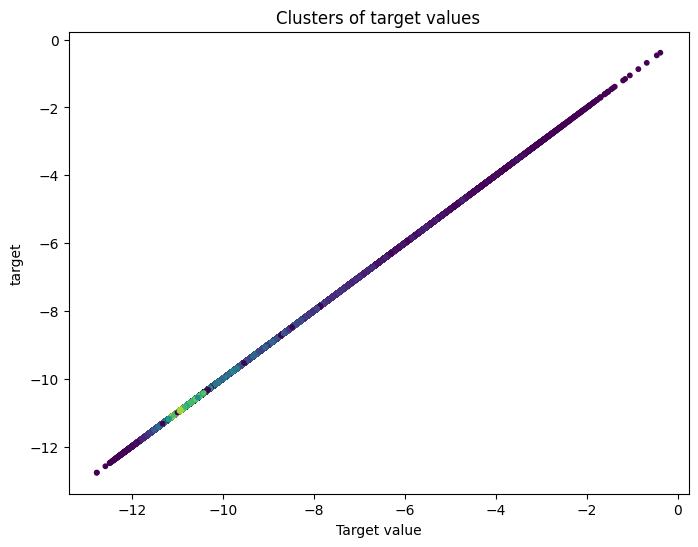

In [6]:
import importlib
from geom3d.utils import target_cluster_split
from geom3d.utils.target_cluster_split import *

importlib.reload(target_cluster_split)

visualize_clusters(dataset, config)

In [19]:
import importlib
from geom3d.utils import oligomer_scaffold_split
from geom3d.utils.oligomer_scaffold_split import *

importlib.reload(oligomer_scaffold_split)

# Calculate average PCA scores and cluster labels
average_pca_scores_array, keys_6mer  = prepare_oligomer_plot(dataset, config)

Calculating the average PCA score for each oligomer: 100%|██████████| 82204/82204 [00:20<00:00, 3982.94it/s]

Problematic keys: []
Number of Oligomers not converted: 0
PCA scores converted


PCA scores array shape: (80000, 2)
Cluster labels shape: (80000,)


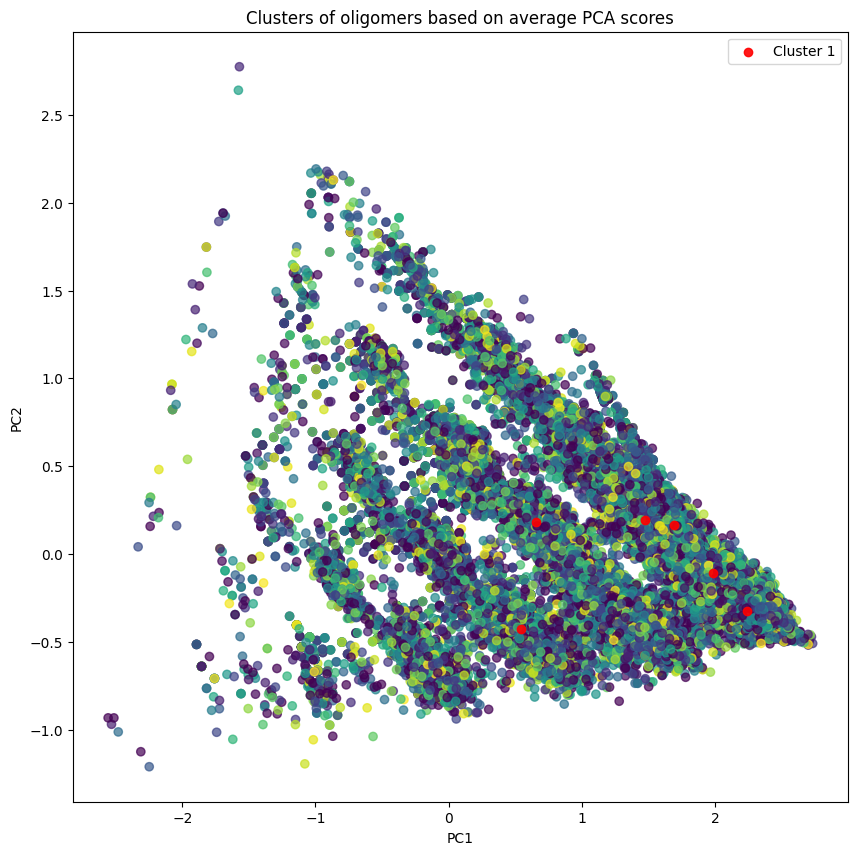

In [23]:
# Get the target column 'y' from each dictionary in the list
target = np.array([data['y'] for data in dataset])
# Cluster the target values using DBSCAN based on density
clusterer = HDBSCAN(min_cluster_size=5)
clusters = clusterer.fit_predict(target.reshape(-1, 1))


In [24]:
selected_cluster = 1 #config["test_set_target_cluster"]  # Choose the cluster you want to use for the test set

# take the indices of average_pca_scores_array that correspond to the keys in keys_dataset
indices = np.where(np.isin(keys_6mer, [data['InChIKey'] for data in dataset]))[0]


IndexError: index 80000 is out of bounds for axis 0 with size 80000

In [ ]:

# remove the indices that are not in keys_dataset
average_pca_scores_array = average_pca_scores_array[indices]

# print array sizes
print(f"PCA scores array shape: {average_pca_scores_array.shape}")
print(f"Cluster labels shape: {clusters.shape}")

df_selected_cluster = pd.DataFrame({
    'PCA1': average_pca_scores_array[:, 0],
    'PCA2': average_pca_scores_array[:, 1],
    'Cluster': clusters
})

# Plot all clusters
plt.figure(figsize=(10, 10))
plt.scatter(df_selected_cluster['PCA1'], clusters, c=df_selected_cluster['Cluster'], cmap='viridis', alpha=0.7)

# Highlight the specific cluster
df_cluster_spec = df_selected_cluster[df_selected_cluster['Cluster'] == selected_cluster]
plt.scatter(df_cluster_spec['PCA1'], clusters, c='red', label=f'Cluster {selected_cluster}', alpha=0.9)

plt.legend()
plt.title("Clusters of oligomers based on average PCA scores")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()